In [ ]:
"""
I need to create a script that takes in stock data, and does a forecast based on daily close prices.
"""

In [147]:
import os
from dotenv import load_dotenv
load_dotenv()
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pylab import rcParams
import glob
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import requests

In [148]:
import alpaca_trade_api as tradeapi
api_key = os.getenv("ALPACA_API_KEY")
secret_key = os.getenv("ALPACA_SECRET_KEY")
api = tradeapi.REST(
    api_key,
    secret_key,
    api_version = "v2"
)

ticker = input()
timeframe = "1D"

# Get daily price data for stocks
barset = api.get_barset(
    ticker,
    timeframe,
    limit=1000
    ).df
stock_data = barset[f'{ticker}']
stock_data.rename_axis('date', inplace=True)
def stock_close(stock_data=stock_data):
    stock_close = stock_data['close']
    return stock_close
stock_close = stock_close()

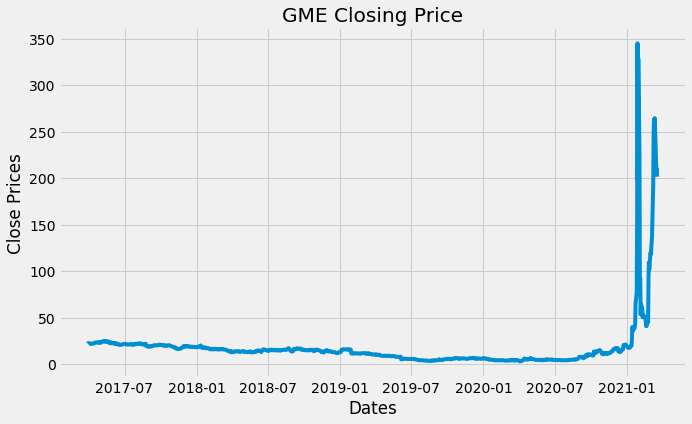

In [149]:
#def create_data():
#csvpath = Path('../data/tickers/HPE.csv')
#data = pd.read_csv(csvpath, parse_dates=True, index_col='Date')

def plot_close_price(data):
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Close Prices')
    plt.plot(stock_close)
    plt.title(f'{ticker} Closing Price')
    return plt.show()
plot_close_price(stock_data)

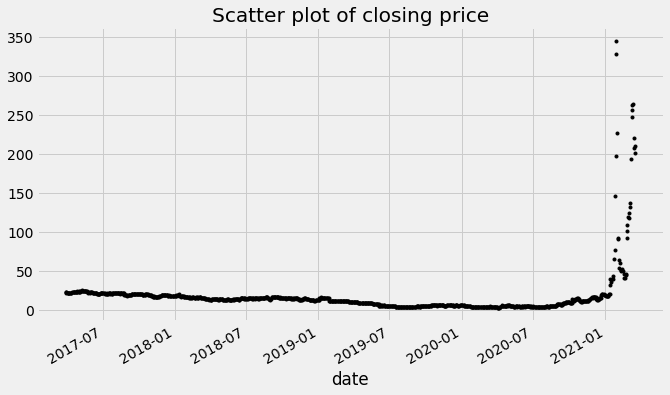

In [150]:
#def closing_df(time_series):
    #df_close = time_series['close']
    #return df_close

stock_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

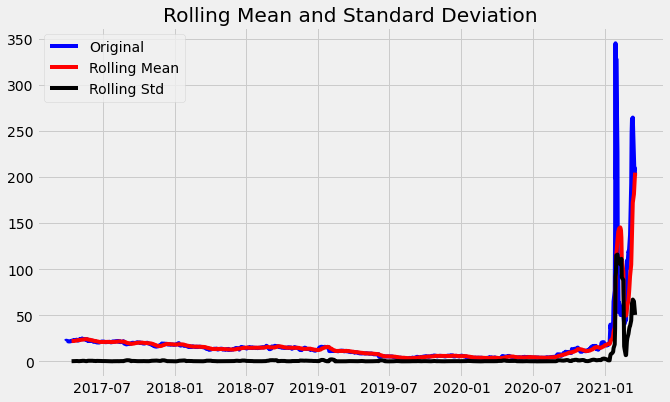

Results of dickey fuller test
Test Statistics                  2.545448
p-value                          0.999063
No. of lags used                20.000000
Number of observations used    979.000000
critical value (1%)             -3.437047
critical value (5%)             -2.864497
critical value (10%)            -2.568344
dtype: float64


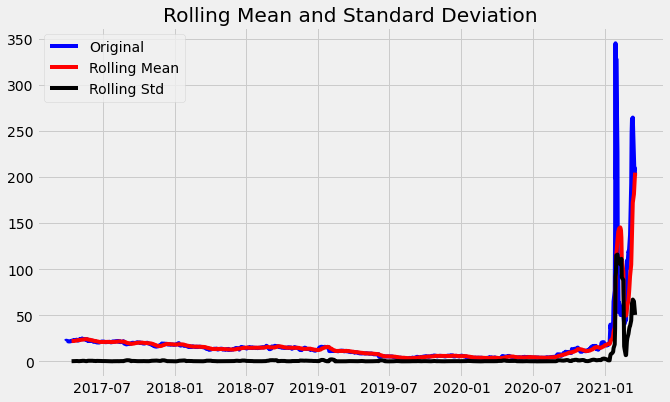

Results of dickey fuller test
Test Statistics                  2.545448
p-value                          0.999063
No. of lags used                20.000000
Number of observations used    979.000000
critical value (1%)             -3.437047
critical value (5%)             -2.864497
critical value (10%)            -2.568344
dtype: float64


In [151]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    p_value = adft[1]
    return p_value
    
test_stationarity(stock_close)
p_value = test_stationarity(stock_close)

No handles with labels found to put in legend.


<Figure size 720x432 with 0 Axes>

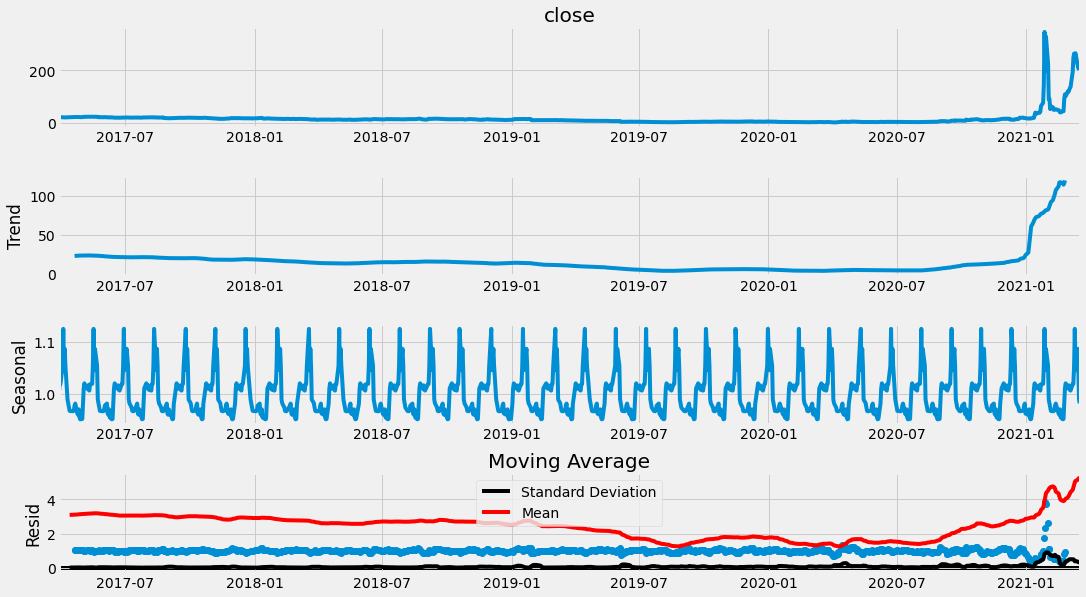

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  896
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1475.255
Method:                       css-mle   S.D. of innovations              0.047
Date:                Thu, 18 Mar 2021   AIC                          -2942.510
Time:                        16:30:29   BIC                          -2923.318
Sample:                             1   HQIC                         -2935.177
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.002     -0.278      0.781      -0.003       0.003
ar.L1.D.close     0.1938      1.763      0.110      0.912      -3.262       3.649
ma.L1.D.close    -0.1913      1.767     

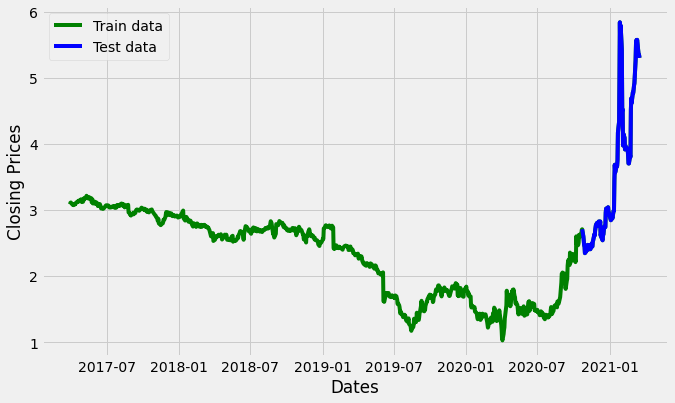

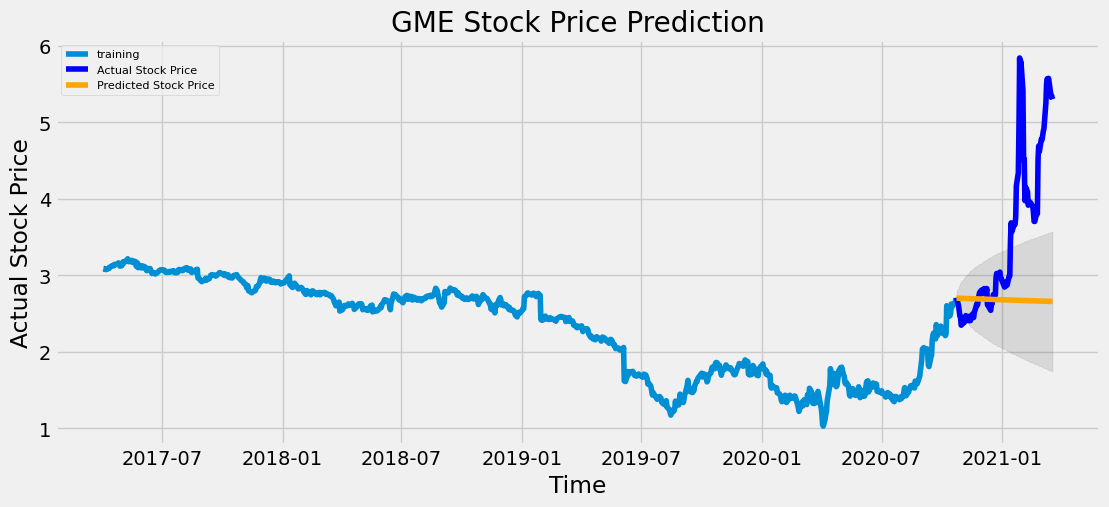

MSE: 1.833612043188577
MAE: 0.9435333951179125
RMSE: 1.3541093172962724
MAPE: 0.21702637120653434
Model is %78.3 accurate in predicting test set observations, based on Mean Absolute Percentage Error.
__________________________________________________________
This stock is forecasted to go down in the short term, based on the last 1000 trading days.


In [152]:

if p_value < 0.05:
    train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(df_log, 'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()

    #model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
     #                 test='adf',       # use adftest to find optimal 'd'
      #                max_p=3, max_q=3, # maximum p and q
       #               m=1,              # frequency of series
        #              d=None,           # let model determine 'd'
         #             seasonal=False,   # No Seasonality
          #            start_P=0, 
           #           D=0, 
            #          trace=True,
             #         error_action='ignore',  
              #        suppress_warnings=True, 
               #       stepwise=True)
    #print(model_autoARIMA.summary())

    #model_autoARIMA.plot_diagnostics(figsize=(15,8))
    #plt.show()
    
    model = ARIMA(train_data, order=(1, 1, 1))  
    fitted = model.fit(disp=-1)  
    print(fitted.summary())

    # Forecast
    fc, se, conf = fitted.forecast(100, alpha=0.05)  # 95% confidence
    fc_series = pd.Series(fc, index=test_data.index)
    lower_series = pd.Series(conf[:, 0], index=test_data.index)
    upper_series = pd.Series(conf[:, 1], index=test_data.index)
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, color = 'blue', label='Actual Stock Price')
    plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                    color='k', alpha=.10)
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Actual Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    mse = mean_squared_error(test_data, fc)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(test_data, fc)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(test_data, fc))
    print('RMSE: '+str(rmse))
    mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
    print('MAPE: '+str(mape))
    print('__________________________________________________________')
    print(f"Model is %{100 - round(mape * 100, 2)} accurate in predicting test set observations, based on Mean Absolute Percentage Error.")
    print('__________________________________________________________')
    if fc_series[-1] > fc_series[0]:
        print('This stock is forecasted to go up in the short term, based on the last 1000 trading days.')
    elif fc_series[0] > fc_series[-1]:
        print('This stock is forecasted to go down in the short term, based on the last 1000 trading days.')
else:
    result = seasonal_decompose(stock_close, model='multiplicative', freq = 30)
    fig = plt.figure()  
    fig = result.plot()  
    fig.set_size_inches(16, 9)
    
    rcParams['figure.figsize'] = 10, 6
    df_log = np.log(stock_close)
    moving_avg = df_log.rolling(12).mean()
    std_dev = df_log.rolling(12).std()
    plt.legend(loc='best')
    plt.title('Moving Average')
    plt.plot(std_dev, color ="black", label = "Standard Deviation")
    plt.plot(moving_avg, color="red", label = "Mean")
    plt.legend()
    plt.show()

    train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(df_log, 'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()

    #model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
     #               test='adf',       # use adftest to find optimal 'd'
      #              max_p=3, max_q=3, # maximum p and q
       #             m=1,              # frequency of series
        #            d=None,           # let model determine 'd'
         #           seasonal=False,   # No Seasonality
          #          start_P=0, 
           #         D=0, 
            #        trace=True,
             #       error_action='ignore',  
              #      suppress_warnings=True, 
               #     stepwise=True)
    #print(model_autoARIMA.summary())

    #model_autoARIMA.plot_diagnostics(figsize=(15,8))
    #plt.show()
    
    model = ARIMA(train_data, order=(1, 1, 1))  
    fitted = model.fit(disp=-1)  
    print(fitted.summary())

    # Forecast
    fc, se, conf = fitted.forecast(100, alpha=0.05)  # 95% confidence
    fc_series = pd.Series(fc, index=test_data.index)
    lower_series = pd.Series(conf[:, 0], index=test_data.index)
    upper_series = pd.Series(conf[:, 1], index=test_data.index)
    plt.figure(figsize=(12,5), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, color = 'blue', label='Actual Stock Price')
    plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                    color='k', alpha=.10)
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Actual Stock Price')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    mse = mean_squared_error(test_data, fc)
    print('MSE: '+str(mse))
    mae = mean_absolute_error(test_data, fc)
    print('MAE: '+str(mae))
    rmse = math.sqrt(mean_squared_error(test_data, fc))
    print('RMSE: '+str(rmse))
    mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
    print('MAPE: '+str(mape))

    print(f"Model is %{100 - round(mape * 100, 2)} accurate in predicting test set observations, based on Mean Absolute Percentage Error.")
    print('__________________________________________________________')
    if fc_series[-1] > fc_series[0]:
        print('This stock is forecasted to go up in the short term, based on the last 1000 trading days.')
    elif fc_series[0] > fc_series[-1]:
        print('This stock is forecasted to go down in the short term, based on the last 1000 trading days.')

<Figure size 720x432 with 0 Axes>

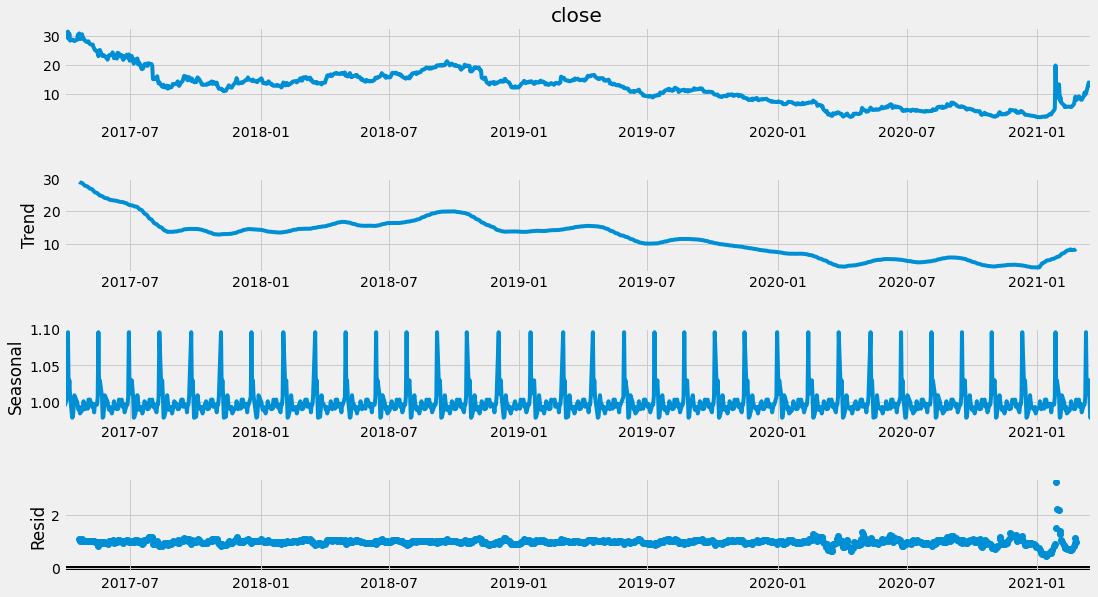

In [139]:
result = seasonal_decompose(stock_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


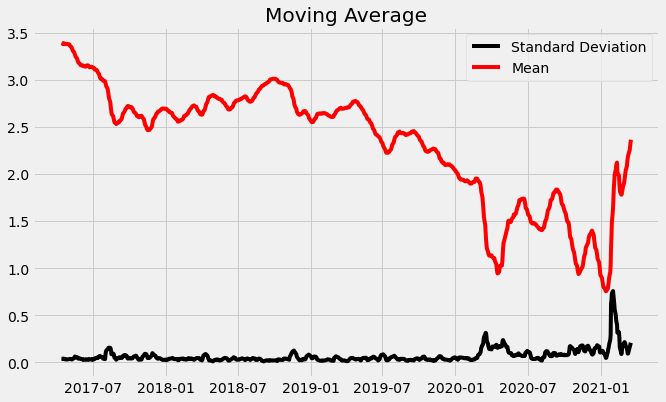

In [140]:

rcParams['figure.figsize'] = 10, 6
df_log = np.log(stock_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

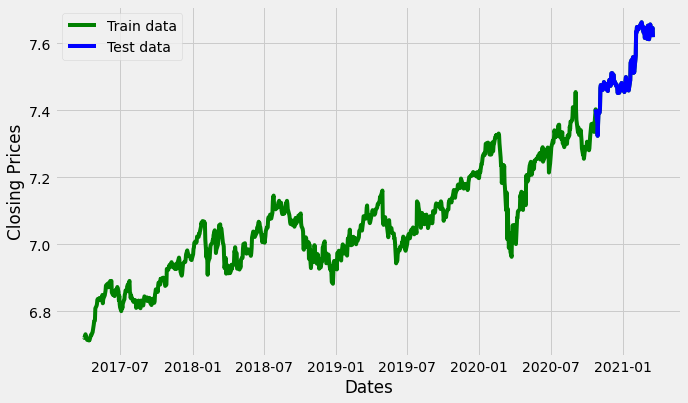

In [125]:

    #split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [126]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
#print(model_autoARIMA.summary())
model_autoARIMA.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6052.795, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-4663.119, Time=0.27 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-4616.416, Time=0.39 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-4661.115, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.46 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-4666.690, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1946.795, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-4665.632, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-4665.319, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-831.584, Time

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  897
Model:               SARIMAX(1, 0, 1)   Log Likelihood                2337.345
Date:                Thu, 18 Mar 2021   AIC                          -4666.690
Time:                        16:22:19   BIC                          -4647.493
Sample:                             0   HQIC                         -4659.355
                                - 897                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0418      0.020      2.135      0.033       0.003       0.080
ar.L1          0.9941      0.003    354.217      0.000       0.989       1.000
ma.L1         -0.1426      0.022     -6.486      0.000      -0.186      -0.099
sigma2         0.0003   8.59e-06     36.987      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):              1044.61
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               2.32   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

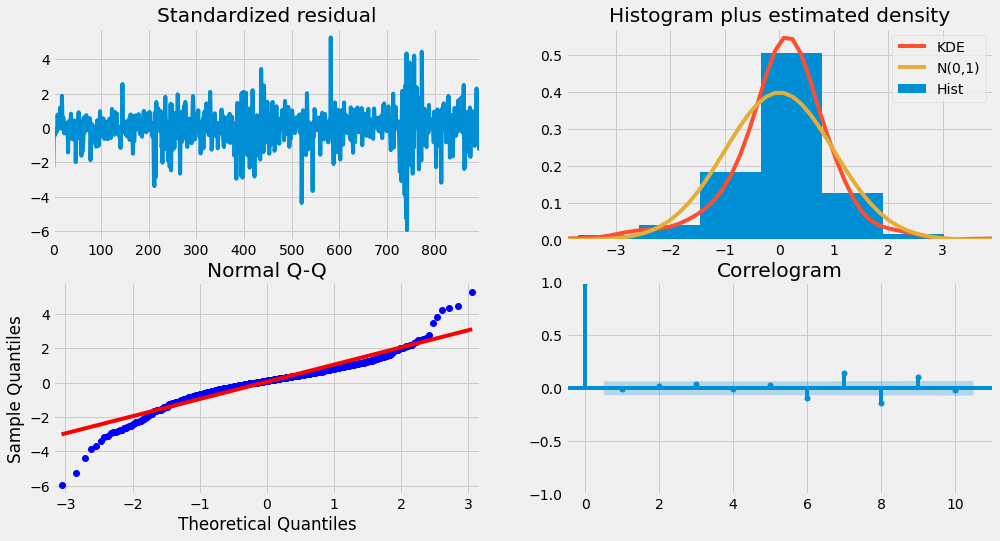

In [127]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [128]:
model = ARIMA(train_data, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())


                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  896
Model:                 ARIMA(1, 1, 1)   Log Likelihood                2339.178
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 18 Mar 2021   AIC                          -4670.357
Time:                        16:22:19   BIC                          -4651.165
Sample:                             1   HQIC                         -4663.024
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.001      1.436      0.151      -0.000       0.002
ar.L1.D.close    -0.1082      0.177     -0.612      0.540      -0.455       0.238
ma.L1.D.close    -0.0499      0.177     

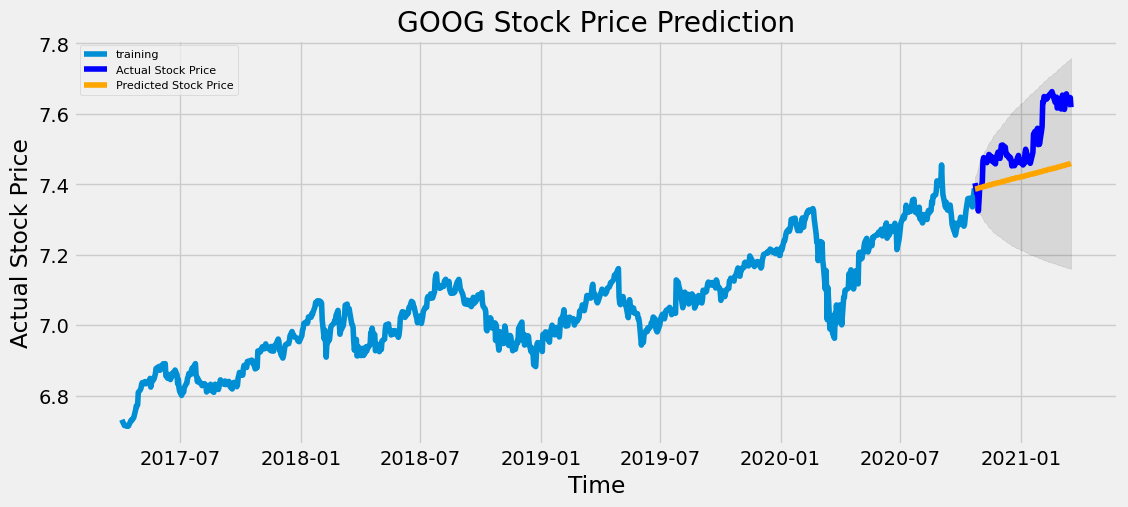

In [132]:
# Forecast
fc, se, conf = fitted.forecast(100, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [102]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.11028307533804126
MAE: 0.29250664779260205
RMSE: 0.3320889569649091
MAPE: 0.11388492470159925


In [103]:
print(f"Model is %{100 - round(mape * 100, 2)} accurate in predicting test set observations, based on Mean Absolute Percentage Error.")

Model is %88.61 accurate in predicting test set observations, based on Mean Absolute Percentage Error.
